In [2]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import tqdm

from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import cmasher as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

import load_data as ld
import optimise as opt
import scatters as opt_sc
import init_latents as il
import kfold_cv as kf

import time

file_name = '-test-rgbs'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-giants-test-GGsnr/'
file_path = '../data/master-APOGEE-giants-test-GGsnr.fits'
spectra_data, label_data = ld.load_data(spectra_dir_path, file_path, file_name)


../spec/spectra-reference-stars-APOGEE-giants-test-GGsnr/spectra_data-test-rgbs.dat
File already exists. Loading spectra data


24it [00:00, 78.99it/s]

Loaded data successfully


In [3]:
test_ID = label_data['ids']
test_flux = spectra_data['fluxes']
test_flux_err = spectra_data['fluxes_err']
test_flux_ivar = spectra_data['fluxes_ivars']
test_label = label_data['labels']
test_label_err = label_data['labels_err']
test_label_ivar = label_data['labels_ivars']

In [4]:
l2reg = 1000
latent_dim = 'P49'
savepath = '../sav/paper/'
name = '_'+str(latent_dim)+'_L2regstrength'+str(l2reg)+'_omega1-train-highsnrgiants'
alphas = np.load(savepath+'alphas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
betas = np.load(savepath+'betas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
zetas = np.load(savepath+'zetas_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
ln_noise_fluxes_updated = jnp.log(np.load(savepath+'noise_fluxes_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True))


# compute the new zetas

In [5]:
# first using the fluxes
P = 49
alphas_init_test, betas_init_test, zetas_init_test = il.initialise_alphas_betas_zetas(test_label, test_flux, P)

In [6]:
res_zetas_fromfluxes = opt_sc.get_zetas_test_using_fluxes(test_flux, test_flux_ivar, betas, zetas_init_test, ln_noise_fluxes_updated)
zetas_test_fromfluxes = res_zetas_fromfluxes.params['zetas']

KeyboardInterrupt: 

In [6]:
labels_test_fromflux = zetas_test_fromfluxes @ alphas.T
spectra_test_fromflux = zetas_test_fromfluxes @ betas.T

In [7]:
savepath = '../sav/paper/'
name = '_49_L2regstrength1000_omega1-train-lowsnrgiants'
np.save(savepath+'zetas_test_fromflux_giants-withscatters'+str(name), zetas_test_fromfluxes)
np.save(savepath+'labels_test_fromflux_giants-withscatters'+str(name), labels_test_fromflux)
np.save(savepath+'spectra_test_fromflux_giants-withscatters'+str(name), spectra_test_fromflux)

In [7]:
savepath = '../sav/paper/'
name = '_49_L2regstrength1000_omega1-train-lowsnrgiants'
zetas_test_fromfluxes = np.load(savepath+'zetas_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
labels_test_fromflux = np.load(savepath+'labels_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
spectra_test_fromflux = np.load(savepath+'spectra_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)

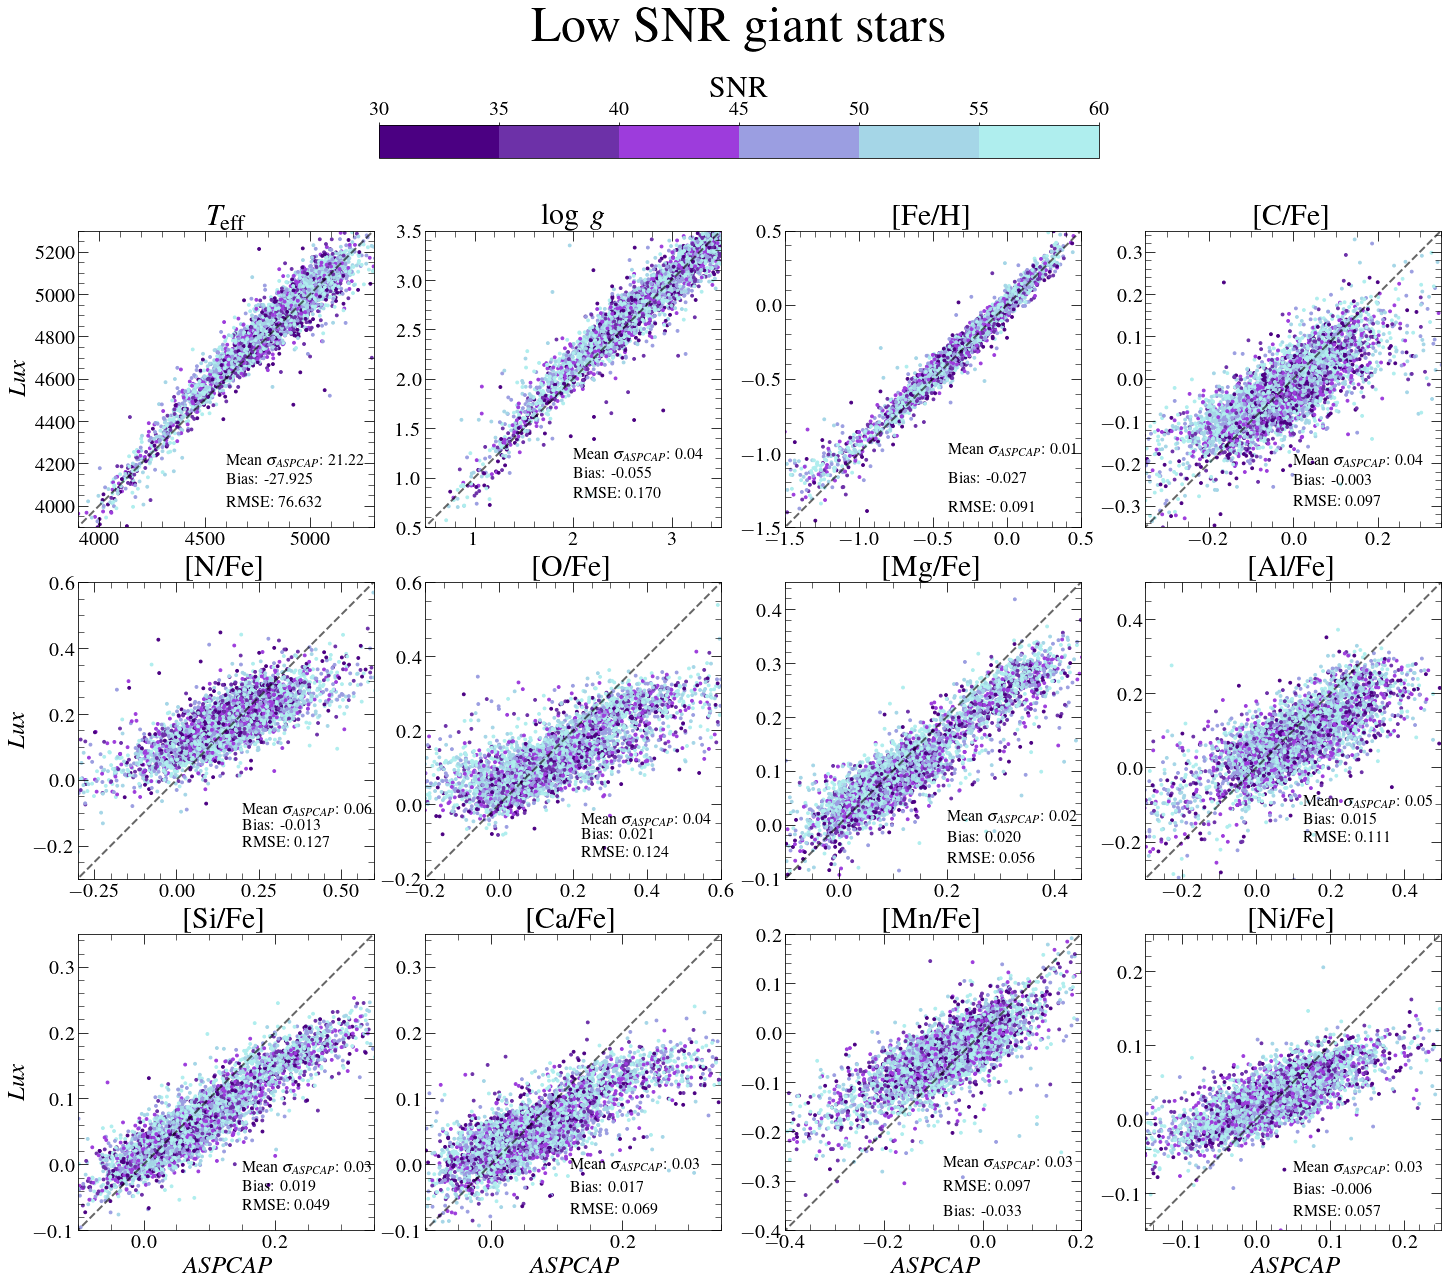

In [20]:
colors = ['indigo','rebeccapurple', 'blueviolet', 'mediumorchid','skyblue', 'lightblue', 'paleturquoise']
cmap1 = LinearSegmentedColormap.from_list("mycmap1", colors, N=6)
minval = 30
maxval = 60
bounds = np.linspace(minval, maxval, 7)
n = 5000

fig = plt.figure(figsize=(20,15), constrained_layout=True)
fig.suptitle('Low SNR giant stars',fontsize=50,x=0.51,y=1.18)

plt.subplot(3,4,1)
plt.title('$T_{\mathrm{eff}}$', fontsize=30)
plt.plot([3500,5500], [3500,5500], color='k',alpha=0.6, lw=2, ls='dashed')
color = plt.scatter(test_label[:n,0], labels_test_fromflux[:,0], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.text(4600,4000, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,0]-labels_test_fromflux[:,0])**2))))), fontsize=16)
plt.text(4600,4100, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,0]-labels_test_fromflux[:,0]))), fontsize=16)
plt.text(4600,4200, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,0]))), fontsize=16)
plt.xlim(3900,5300)
plt.ylim(3900,5300)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.ylabel(r'$Lux$', fontsize=25)

plt.subplot(3,4,2)
plt.title('$\log~g$', fontsize=30)
plt.plot([0,4],[0,4], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(2.,0.8, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,1]-labels_test_fromflux[:,1])**2))))), fontsize=16)
plt.text(2.,1., 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,1]-labels_test_fromflux[:,1]))), fontsize=16)
plt.text(2.,1.2, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,1]))), fontsize=16)
plt.scatter(test_label[:n,1], labels_test_fromflux[:,1], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(0.5,3.5)
plt.ylim(0.5,3.5)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,3)
plt.title('[Fe/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.4,-1.4, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,2]-labels_test_fromflux[:,2])**2))))), fontsize=16)
plt.text(-0.4,-1.2, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,2]-labels_test_fromflux[:,2]))), fontsize=16)
plt.text(-0.4,-1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,2]))), fontsize=16)
plt.scatter(test_label[:n,2], labels_test_fromflux[:,2], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(-1.5,0.5)
plt.ylim(-1.5,0.5)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,4)
plt.title('[C/Fe]', fontsize=30)
plt.plot([-0.8,0.8], [-0.8,0.8], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.0,-0.3, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,3]-labels_test_fromflux[:,3])**2))))), fontsize=16)
plt.text(0.0,-0.25, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,3]-labels_test_fromflux[:,3]))), fontsize=16)
plt.text(0.0,-0.2, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,3]))), fontsize=16)
plt.scatter(test_label[:n,3], labels_test_fromflux[:,3], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(-0.35,0.35)
plt.ylim(-0.35,0.35)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,5)
plt.title('[N/Fe]', fontsize=30)
plt.plot([-0.5,1.], [-0.5,1.], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.2,-0.2, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,4]-labels_test_fromflux[:,4])**2))))), fontsize=16)
plt.text(0.2,-0.15, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,4]-labels_test_fromflux[:,4]))), fontsize=16)
plt.text(0.2,-0.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,4]))), fontsize=16)
plt.scatter(test_label[:n,4], labels_test_fromflux[:,4], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(-0.3,0.6)
plt.ylim(-0.3,0.6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.ylabel(r'$Lux$', fontsize=25)

plt.subplot(3,4,6)
plt.title('[O/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.22,-0.14, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,5]-labels_test_fromflux[:,5])**2))))), fontsize=16)
plt.text(0.22,-0.09, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,5]-labels_test_fromflux[:,5]))), fontsize=16)
plt.text(0.22,-0.05, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,5]))), fontsize=16)
plt.scatter(test_label[:n,5], labels_test_fromflux[:,5], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(-0.2,0.6)
plt.ylim(-0.2,0.6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,7)
plt.title('[Mg/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.2,-0.07, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,6]-labels_test_fromflux[:,6])**2))))), fontsize=16)
plt.text(0.2,-0.03, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,6]-labels_test_fromflux[:,6]))), fontsize=16)
plt.text(0.2,0.01, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,6]))), fontsize=16)
plt.scatter(test_label[:n,6], labels_test_fromflux[:,6], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(-0.1,0.45)
plt.ylim(-0.1,0.45)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,8)
plt.title('[Al/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.125,-0.2, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,7]-labels_test_fromflux[:,7])**2))))), fontsize=16)
plt.text(0.125,-0.15, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,7]-labels_test_fromflux[:,7]))), fontsize=16)
plt.text(0.125,-0.1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,7]))), fontsize=16)
plt.scatter(test_label[:n,7], labels_test_fromflux[:,7], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(-0.3,0.5)
plt.ylim(-0.3,0.5)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,9)
plt.title('[Si/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.15,-0.07, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,8]-labels_test_fromflux[:,8])**2))))), fontsize=16)
plt.text(0.15,-0.04, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,8]-labels_test_fromflux[:,8]))), fontsize=16)
plt.text(0.15,-0.01, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,8]))), fontsize=16)
plt.scatter(test_label[:n,8], labels_test_fromflux[:,8], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(-0.1,0.35)
plt.ylim(-0.1,0.35)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.ylabel(r'$Lux$', fontsize=25)
plt.xlabel(r'$ASPCAP$', fontsize=25)

plt.subplot(3,4,10)
plt.title('[Ca/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.12,-0.075, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,9]-labels_test_fromflux[:,9])**2))))), fontsize=16)
plt.text(0.12,-0.04, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,9]-labels_test_fromflux[:,9]))), fontsize=16)
plt.text(0.12,-0.005, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,9]))), fontsize=16)
plt.scatter(test_label[:n,9], labels_test_fromflux[:,9], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(-0.1,0.35)
plt.ylim(-0.1,0.35)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'$ASPCAP$', fontsize=25)

plt.subplot(3,4,11)
plt.title('[Mn/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.08,-0.32, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,10]-labels_test_fromflux[:,10])**2))))), fontsize=16)
plt.text(-0.08,-0.37, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,10]-labels_test_fromflux[:,10]))), fontsize=16)
plt.text(-0.08,-0.27, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,10]))), fontsize=16)
plt.scatter(test_label[:n,10], labels_test_fromflux[:,10], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(-0.4,0.2)
plt.ylim(-0.4,0.2)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'$ASPCAP$', fontsize=25)

plt.subplot(3,4,12)
plt.title('[Ni/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.05,-0.13, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,11]-labels_test_fromflux[:,11])**2))))), fontsize=16)
plt.text(0.05,-0.1, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,11]-labels_test_fromflux[:,11]))), fontsize=16)
plt.text(0.05,-0.07, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,11]))), fontsize=16)
plt.scatter(test_label[:n,11], labels_test_fromflux[:,11], s=8, rasterized=True, c=label_data['snr'][:n], vmin=30,vmax=60, cmap=cmap1)
plt.xlim(-0.15,0.25)
plt.ylim(-0.15,0.25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'$ASPCAP$', fontsize=25)

cbar_ax = fig.add_axes([0.26, 1.04, 0.5,0.03])
cbar = fig.colorbar(color, ticks=bounds, cax = cbar_ax,orientation='horizontal')
cbar.set_label(label=r'SNR',fontsize=30)
cbar.ax.tick_params(labelsize=20)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.savefig('../plots/paper/cv-lowsnr-lux.pdf',dpi=200, bbox_inches = 'tight')

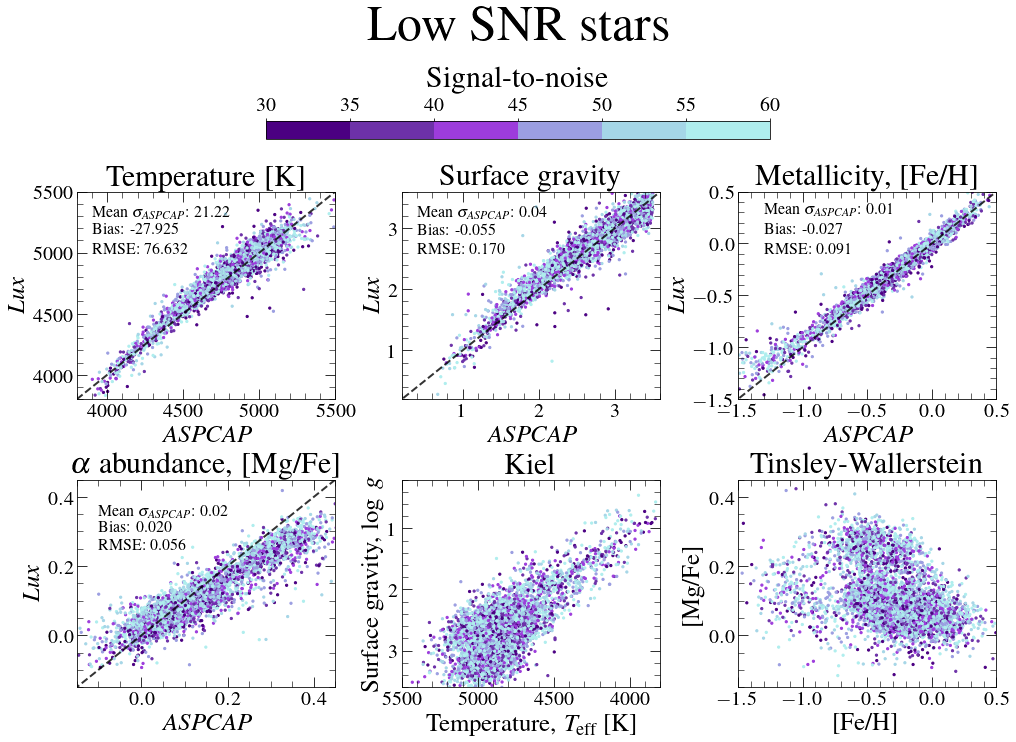

In [19]:
colors = ['indigo','rebeccapurple', 'blueviolet', 'mediumorchid','skyblue', 'lightblue', 'paleturquoise']
cmap1 = LinearSegmentedColormap.from_list("mycmap1", colors, N=6)
minval = 30
maxval = 60
bounds = np.linspace(minval, maxval, 7)

fig = plt.figure(figsize=(14,8), constrained_layout=True)
fig.suptitle(r'Low SNR stars',fontsize=50,x=0.51,y=1.27)

plt.subplot(2,3,1)
# plt.title('$T_{\mathrm{eff}}$', fontsize=30)
plt.title('Temperature [K]', fontsize=30)
plt.plot([3800,5500], [3800,5500], color='k',alpha=0.8, lw=2, ls='--')
color = plt.scatter(test_label[:,0], labels_test_fromflux[:,0], s=5, rasterized=True, c=label_data['snr'], vmin=30,vmax=60, cmap=cmap1)
plt.text(3900,5000, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,0]-labels_test_fromflux[:,0])**2))))), fontsize=16)
plt.text(3900,5150, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,0]-labels_test_fromflux[:,0]))), fontsize=16)
plt.text(3900,5300, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,0]))), fontsize=16)
plt.xlim(3800,5500)
plt.ylim(3800,5500)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.ylabel(r'$Lux$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,2)
plt.title('Surface gravity', fontsize=30)
plt.plot([0,3.6],[0,3.6], color='k',alpha=0.8, lw=2, ls='--')
plt.scatter(test_label[:,1], labels_test_fromflux[:,1], s=5, rasterized=True, c=label_data['snr'], vmin=30,vmax=60, cmap=cmap1)
plt.text(0.4,2.6, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,1]-labels_test_fromflux[:,1])**2))))), fontsize=16)
plt.text(0.4,2.9, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,1]-labels_test_fromflux[:,1]))), fontsize=16)
plt.text(0.4,3.2, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,1]))), fontsize=16)
plt.xlim(0.2,3.6)
plt.ylim(0.2,3.6)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.ylabel(r'$Lux$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,3)
plt.title('Metallicity, [Fe/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.8, lw=2, ls='--')
plt.scatter(test_label[:,2], labels_test_fromflux[:,2], s=5, rasterized=True, c=label_data['snr'], vmin=30,vmax=60, cmap=cmap1)
plt.text(-1.3,-0.1, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,2]-labels_test_fromflux[:,2])**2))))), fontsize=16)
plt.text(-1.3,0.1, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,2]-labels_test_fromflux[:,2]))), fontsize=16)
plt.text(-1.3,0.3, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,2]))), fontsize=16)
plt.xlim(-1.5,0.5)
plt.ylim(-1.5,0.5)
plt.ylabel(r'$Lux$', fontsize=25)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,4)
plt.title(r'$\alpha$ abundance, [Mg/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.8, lw=2, ls='--')
plt.scatter(test_label[:,6], labels_test_fromflux[:,6], s=5, rasterized=True, c=label_data['snr'], vmin=30,vmax=60, cmap=cmap1)
plt.text(-0.1,0.25, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,6]-labels_test_fromflux[:,6])**2))))), fontsize=16)
plt.text(-0.1,0.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,6]-labels_test_fromflux[:,6]))), fontsize=16)
plt.text(-0.1,0.35, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,6]))), fontsize=16)
plt.xlim(-0.15,0.45)
plt.ylim(-0.15,0.45)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.ylabel(r'$Lux$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,5)
plt.title('Kiel', fontsize=30)
plt.scatter(labels_test_fromflux[:,0], labels_test_fromflux[:,1], s=5, rasterized=True, c=label_data['snr'], vmin=30,vmax=60, cmap=cmap1)

plt.xlim(5500, 3800)
plt.ylim(3.6, 0.2)
plt.xlabel(r'Temperature, $T_{\mathrm{eff}}$ [K]', fontsize=25)
plt.ylabel(r'Surface gravity, $\log~g$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,6)
plt.title('Tinsley-Wallerstein', fontsize=30)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,6], s=5, rasterized=True, c=label_data['snr'], vmin=30,vmax=60, cmap=cmap1)

plt.xlim(-1.5,0.5)
plt.ylim(-0.15,0.45)
plt.xlabel(r'[Fe/H]', fontsize=25)
plt.ylabel(r'[Mg/Fe]', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()



cbar_ax = fig.add_axes([0.26, 1.04, 0.5,0.03])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
cbar.set_label(label=r'Signal-to-noise',fontsize=30, labelpad=10)
cbar.ax.tick_params(labelsize=20)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.savefig('../plots/paper/lowsnr-lux.pdf',dpi=200, bbox_inches = 'tight')